The uploaded file details a machine learning project that classifies a developer's role based on their Git commit data. The process includes data preparation, feature engineering, and training several classification models.
### Data Preprocessing and Feature Engineering
The initial steps focus on converting raw data into a numerical format suitable for machine learning models.

* *Handling Categorical Features: The file extensions and commit-related timestamps are processed. The fileextensions column, which contains lists of file types, is transformed into a binary matrix using MultiLabelBinarizer after the train-test split. This creates new columns for each unique file type, with a '1' indicating its presence and a '0' its absence. The timeofcommit column is first separated into day and time, then the time is categorized into "Morning", "Afternoon", "Evening", and "Night". The day, time, and committype columns are then converted into numerical features using **one-hot encoding*.

* *Text Processing for Commit Messages*: The commitmessage text is cleaned and prepared for analysis. A custom preprocess_text function performs several steps:
    1.  *Lowercasing*: All text is converted to lowercase to ensure consistency.
    2.  *Punctuation Removal*: Punctuation is removed to focus only on words.
    3.  *Stopword Removal*: Common English words (e.g., "a", "the") are removed because they don't provide significant meaning for classification.
    4.  *Stemming*: The PorterStemmer algorithm reduces words to their root form (e.g., "running" becomes "run"), which helps consolidate similar terms.

* *Text Embeddings: The cleaned text from commitmessage is converted into numerical vectors using **TF-IDF (Term Frequency-Inverse Document Frequency)*. This method assigns a weight to each word based on how frequently it appears in a document versus how rare it is across all documents. Words that are unique to a specific document are given higher importance. The resulting sparse matrix is then used as features for the models.
*
### Model Selection and Evaluation

The notebook evaluates three different classification models, starting with a baseline and progressively introducing more complex methods. The primary metrics used are *accuracy* and *macro F1 score*. Accuracy measures the proportion of correct predictions, while the macro F1 score provides an unweighted average of the F1 score for each class, which is a good indicator of performance across all roles, especially if the dataset is imbalanced.

#### 1. Baseline Model: Logistic Regression
* *Rationale: Logistic Regression, particularly its **Softmax Regression* variant for multi-class problems, was chosen as the baseline due to its simplicity and effectiveness for linear classification problems.
* *Performance*: The model achieved an accuracy of 0.94 and a macro F1 score of 0.9305. The author noted this as a "decent accuracy" and a good starting point for comparison.

#### 2. Experimentation: Decision Tree Classifier
* *Rationale*: The author initially hypothesized that a non-linear model like a Decision Tree would perform better than logistic regression because it could capture more complex relationships in the data.
* *Performance (Initial)*: Without hyperparameter tuning, the Decision Tree Classifier performed exactly the same as the Logistic Regression model, with an accuracy of 0.94 and a macro F1 score of 0.9305. The author noted that the model was "performing exactly same as logistic regression".
* *Hyperparameter Tuning*: To improve the Decision Tree's performance, the author used GridSearchCV to find the optimal hyperparameters. The search space included different criteria (gini, entropy, log_loss), max_depth, min_samples_split, min_samples_leaf, and max_features.
* *Performance (Tuned)*: After tuning, the Decision Tree's performance improved significantly, reaching an accuracy of 0.9667 and a macro F1 score of 0.9635. The best parameters found were {'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 5}. This demonstrates that tuning is crucial for getting the best performance out of a model.

#### 3. Advanced Model: Random Forest Classifier
* *Rationale: As an improvement on the single Decision Tree, a Random Forest was introduced. This is an **ensemble learning* model that combines multiple decision trees. The author's comment explains the key insight: Random Forests use *bagging* (Bootstrap Aggregating) to reduce *variance*. The author notes that the problem seems to be one of "variance, not bias," suggesting that individual decision trees might be overfitting to the training data. By combining many of these trees, a Random Forest can create a more robust and generalized model that is less prone to overfitting.
* *Performance*: The Random Forest Classifier achieved the highest scores of all the models, with an accuracy of 0.9733 and a macro F1 score of 0.9694. This confirms the author's hypothesis that an ensemble method is a better choice for this dataset.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

In [82]:
# load data
df = pd.read_csv('final_dataset.csv').drop(columns=['index'])

In [83]:
# Function to extract file extensions
def extract_file_extensions(text):
    result = [str(x) for x in eval(text)]
    result = list(set(result))
    return result
df["fileextensions"] = df["fileextensions"].apply(extract_file_extensions)

In [84]:
# getting the unique files
unique_files = []

for row in df["fileextensions"]:
    for ext in row:
        if ext not in unique_files:
            unique_files.append(ext)

print(unique_files)

['js_ts', 'css', 'html', 'py', 'test_py', 'java_go', 'test_js', 'md', 'sql', 'yml_json']


In [85]:
# Function to split into (day, time)
def extract_dat(text):
    '''
    The 'timeofcommit' column contains both day and time together as a string.
    Example: "Monday 12:30"
    We split this string into two parts:
    - lst[0] → Day  (e.g., Monday)
    - lst[1] → Time (e.g., 12:30)
    '''
    lst = text.split(" ")
    return (lst[0], lst[1])

# Apply function → gives tuple (day, time)
df['timeofcommit'] = df['timeofcommit'].apply(extract_dat)

'''
After applying the function, each entry in 'timeofcommit' becomes a tuple:
   ("Day", "Time")
This makes it easier to separate them into individual columns.
'''

# Separate into lists
day = []
time = []
for i in df['timeofcommit']:
    '''
    Iterating through each tuple in 'timeofcommit' and storing
    the first element (day) and the second element (time) separately.
    '''
    day.append(i[0])
    time.append(i[1])
    # Create new DataFrame with split columns
extract_df = pd.DataFrame({'day': day, 'time': time})

'''
Now we have a new DataFrame 'extract_df' with two clear columns:
- 'day'
- 'time'
'''

# Concatenate with original df
df = pd.concat([df, extract_df], axis=1)

# Drop old column
df = df.drop(columns='timeofcommit')


#Finally, we:
#1. Concatenate 'day' and 'time' columns back into the original DataFrame.
#2. Drop the old 'timeofcommit' column since it's no longer needed.

# df.head()

In [86]:
# function to categorize time
def get_time_category(t):
    if pd.isna(t):
        return "Unknown"
    hour = int(str(t).split(":")[0])
    if 6 <= hour < 12:
        return "Morning"
    elif 12 <= hour < 18:
        return "Afternoon"
    elif 18 <= hour < 22:
        return "Evening"
    else:
        return "Night"

# Replace time column with categories
df["time"] = df["time"].apply(get_time_category)

# df.head()

In [87]:
## since we have more than one category in each row so using multilabelbinarizer after train test split

In [88]:
# processing file extensions
# Example: assume df is your dataframe and 'role' is your target column
x = df.drop(columns=['role'])   # features
y = df['role']                  # target

# 1. Train-test split
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)
# 2. MultiLabelBinarizer
mlb = MultiLabelBinarizer()
train_encoded = pd.DataFrame(
    mlb.fit_transform(x_train['fileextensions']),
    columns=mlb.classes_,
    index=x_train.index
)
# doing transform only on test data not fit 
test_encoded = pd.DataFrame(
    mlb.transform(x_test['fileextensions']),
    columns=mlb.classes_,
    index=x_test.index
)

# 3. Concatenate encoded features
x_train = pd.concat([x_train.drop(columns='fileextensions'), train_encoded], axis=1)
x_test = pd.concat([x_test.drop(columns='fileextensions'), test_encoded], axis=1)


In [89]:
# now applying one hot encoding on day , time and committype columns
# One-hot encode 'day' , 'committype' and 'time'
train_encoded = pd.get_dummies(x_train, columns=['day', 'time', 'committype'], dtype=int)
test_encoded = pd.get_dummies(x_test, columns=['day', 'time', 'committype'], dtype=int)
test_encoded = test_encoded.reindex(columns=train_encoded.columns, fill_value=0)
x_train = train_encoded
x_test = test_encoded

In [90]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import string
nltk.download('stopwords')
# Function to preprocess text
def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    corps = stopwords.words('english')
    new_text = [' ' if i in corps else i for i in text.split()]
    text = ' '.join(new_text)
    ps = PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

x_train['commitmessage'] = x_train['commitmessage'].apply(preprocess_text)
x_test['commitmessage'] = x_test['commitmessage'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to C:\Users\UTKARSH
[nltk_data]     ROY\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [91]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
embed_train = tfidf.fit_transform(x_train['commitmessage'])
embed_test = tfidf.transform(x_test['commitmessage'])

In [92]:
train_embeddings=pd.DataFrame(embed_train.toarray())

In [93]:
test_embeddings=pd.DataFrame(embed_test.toarray())

In [94]:
# Convert integer column names to strings
train_embeddings.columns = train_embeddings.columns.map(str)
# Convert integer column names to strings
test_embeddings.columns = test_embeddings.columns.map(str)


In [95]:
#x_test= pd.concat([x_test,test_embeddings],axis=1).drop(columns='commitmessage')
#x_train= pd.concat([x_train,train_embeddings],axis=1).drop(columns='commitmessage')

In [96]:
# Reset indices to align properly
x_train = x_train.reset_index(drop=True)
train_embeddings = train_embeddings.reset_index(drop=True)

x_train = pd.concat([x_train, train_embeddings], axis=1).drop(columns="commitmessage")

x_test = x_test.reset_index(drop=True)
test_embeddings = pd.DataFrame(embed_test.toarray()).reset_index(drop=True)

x_test = pd.concat([x_test, test_embeddings], axis=1).drop(columns="commitmessage")


In [97]:
x_train.columns = x_train.columns.astype(str)
x_test.columns = x_test.columns.astype(str)


In [103]:
x_train

,numfileschanged,linesadded,linesdeleted,numcommentsadded,css,html,java_go,js_ts,md,py,...,821,822,823,824,825,826,827,828,829,830
0,2,11,3,2,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,104,53,4,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,49,33,4,1,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2,299,162,3,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,167,82,8,0,0,0,1,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,7,90,14,7,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1196,1,119,62,4,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1197,1,39,14,2,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1198,1,20,2,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [98]:
'''now comes the model selection for prediction'''
# the starting baseline started with prediction using the softmax classifiation , simply on the basis of probability and the cross
#entropy loss function we use to determine the classification in this.
# this came in mind as this is the most basic that can be applied to a multi class classifiation that is expected to get results
'''the metric for evaluation used is the accuracy score and the macro f1 score
the accuracy score simply tells how many are correctly classified from all
then f1 score is a tradeoff between the precision and reacall , precision tries to reduce the number of false positives and recall
wants less number of false negatives , the f1 score manages the two and is high inly when both are high, f1 score is basically the 
harmonic mean of the two quantities.
the macro f1 score means average of f1 score of all the classes.
'''


''' training the most basline logistic regression model in this. the softmax regression is the most basic for multiclass classification.
This came in mind because of the multi lass classification
'''
# Train and evaluate models
clf = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=500)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))
print("Logistic Regression F1 Score:", f1_score(y_test, y_pred, average='macro'))

''' A decent accuracy can be observed from this'''

C:\Users\UTKARSH ROY\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression Accuracy: 0.94
Logistic Regression F1 Score: 0.9305192244495564


C:\Users\UTKARSH ROY\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


' A decent accuracy can be observed from this'

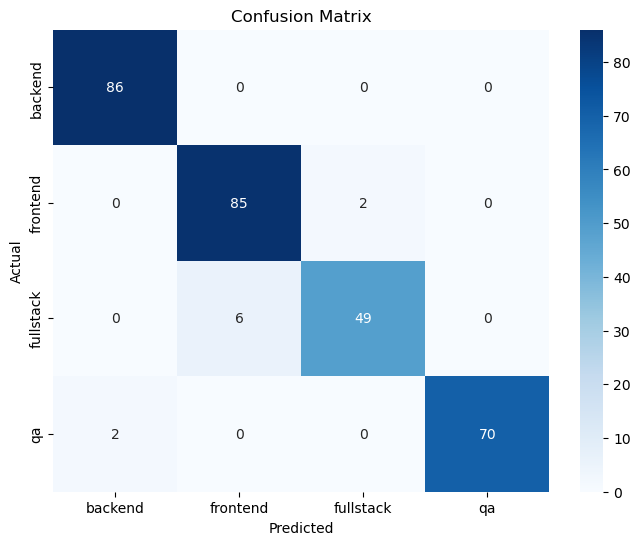

Classification Report:
              precision    recall  f1-score   support

     backend       0.98      1.00      0.99        86
    frontend       0.93      0.98      0.96        87
   fullstack       0.96      0.89      0.92        55
          qa       1.00      0.97      0.99        72

    accuracy                           0.97       300
   macro avg       0.97      0.96      0.96       300
weighted avg       0.97      0.97      0.97       300



In [104]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", 
            xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Precision, Recall, F1 per class
print("Classification Report:")
print(classification_report(y_test, y_pred))


In [99]:
# now trying to use decision tree as it is a better model compare to softmax regression for multiclass classification as 
# splitting is done better in case of decision tree 
# Train and evaluate Decision Tree Classifier
clf_dt = DecisionTreeClassifier(random_state=42)   # you can tune max_depth, min_samples_split, etc.
clf_dt.fit(x_train, y_train)
y_pred = clf.predict(x_test)

print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred))
print("Decision Tree F1 Score:", f1_score(y_test, y_pred, average='macro'))

'''but as per the scores it can be seen that the decision tree classifier is performing exactly same as  logistic regression'''


Decision Tree Accuracy: 0.94
Decision Tree F1 Score: 0.9305192244495564


'but as per the scores it can be seen that the decision tree classifier is performing exactly same as  logistic regression'

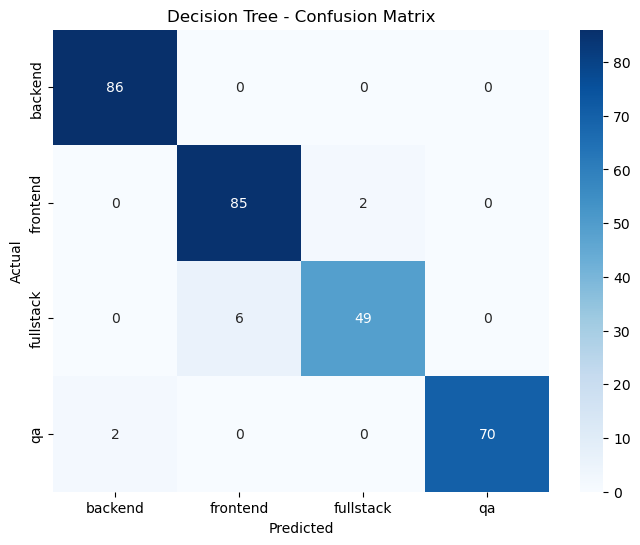

Classification Report for Decision Tree:
              precision    recall  f1-score   support

     backend       0.98      1.00      0.99        86
    frontend       0.93      0.98      0.96        87
   fullstack       0.96      0.89      0.92        55
          qa       1.00      0.97      0.99        72

    accuracy                           0.97       300
   macro avg       0.97      0.96      0.96       300
weighted avg       0.97      0.97      0.97       300



In [106]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", 
            xticklabels=clf_dt.classes_, yticklabels=clf_dt.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Decision Tree - Confusion Matrix")
plt.show()

# Precision, Recall, F1 per class
print("Classification Report for Decision Tree:")
print(classification_report(y_test, y_pred))


In [100]:
# Define the parameter grid for tuning
param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],  # impurity measures
    'max_depth': [None, 5, 10, 20, 30],  # depth of the tree
    'min_samples_split': [2, 5, 10, 20],  # minimum samples to split a node
    'min_samples_leaf': [1, 2, 5, 10],    # minimum samples in a leaf node
    'max_features': [None, 'sqrt', 'log2']  # number of features considered per split
}

# Initialize base model
clf_tuned = DecisionTreeClassifier(random_state=42)

# Grid search with 5-fold CV
grid_search = GridSearchCV(
    estimator=clf_tuned,
    param_grid=param_grid,
    cv=5,
    scoring='f1_macro',   
    n_jobs=-1,            
    verbose=2
)

# Fit grid search
grid_search.fit(x_train, y_train)

# Best model
best_clf = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Predictions
y_pred = best_clf.predict(x_test)
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred))
print("Decision Tree F1 Score:", f1_score(y_test, y_pred, average='macro'))


'''  after the hyperparamter tuning the decision tree accuracy has become much better'''

Fitting 5 folds for each of 720 candidates, totalling 3600 fits
Best Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 5}
Decision Tree Accuracy: 0.9666666666666667
Decision Tree F1 Score: 0.9635014304365642


'  after the hyperparamter tuning the decision tree accuracy has become much better'

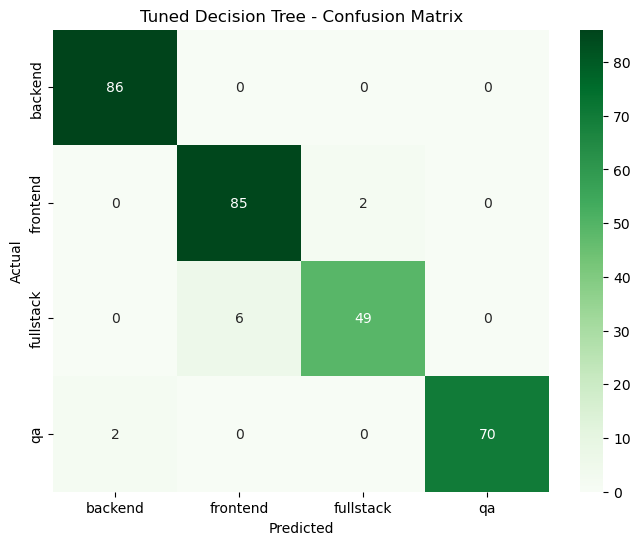

Classification Report for Tuned Decision Tree:
              precision    recall  f1-score   support

     backend       0.98      1.00      0.99        86
    frontend       0.93      0.98      0.96        87
   fullstack       0.96      0.89      0.92        55
          qa       1.00      0.97      0.99        72

    accuracy                           0.97       300
   macro avg       0.97      0.96      0.96       300
weighted avg       0.97      0.97      0.97       300



In [107]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix for tuned model
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Greens", 
            xticklabels=best_clf.classes_, yticklabels=best_clf.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Tuned Decision Tree - Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report for Tuned Decision Tree:")
print(classification_report(y_test, y_pred))


In [102]:
'''Now as a improvement to decision trees and softmax we introduce the random forest'''
rf = RandomForestClassifier(random_state=42)
rf.fit(x_train, y_train)
y_rf_pred = rf.predict(x_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_rf_pred))
print("Random Forest F1 Score:", f1_score(y_test, y_rf_pred, average='macro'))
'''bagging is the better choice because  problem is one of variance, not bias. 
Boosting algorithms excel at fixing bias, and applying them here would be the wrong tool for the job, likely leading to 
significant overfitting.
The patterns are clear and the material is relatively easy for them (low bias). They get 95% of the questions right on their own. 
The main risk is that they 
might overthink a tricky question or get confused by a weirdly phrased one (high variance).
'''

Random Forest Accuracy: 0.9733333333333334
Random Forest F1 Score: 0.9694031458737341


'bagging is the better choice because  problem is one of variance, not bias. \nBoosting algorithms excel at fixing bias, and applying them here would be the wrong tool for the job, likely leading to \nsignificant overfitting.\nThe patterns are clear and the material is relatively easy for them (low bias). They get 95% of the questions right on their own. \nThe main risk is that they \nmight overthink a tricky question or get confused by a weirdly phrased one (high variance).\n'

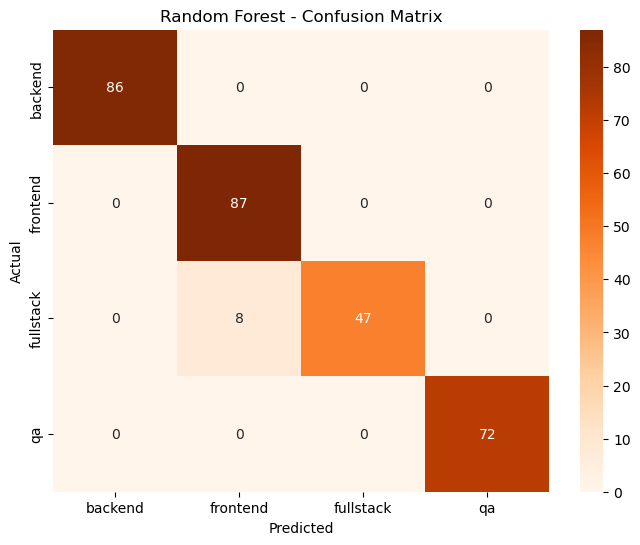

Classification Report for Random Forest:
              precision    recall  f1-score   support

     backend       1.00      1.00      1.00        86
    frontend       0.92      1.00      0.96        87
   fullstack       1.00      0.85      0.92        55
          qa       1.00      1.00      1.00        72

    accuracy                           0.97       300
   macro avg       0.98      0.96      0.97       300
weighted avg       0.98      0.97      0.97       300



In [108]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix for Random Forest
cm = confusion_matrix(y_test, y_rf_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Oranges", 
            xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest - Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report for Random Forest:")
print(classification_report(y_test, y_rf_pred))
